In [193]:
import pandas as pd
from pandas import DataFrame as DataFrame
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import xgboost as xg

In [194]:
PATH_STATIONS_RAW = 'data/raw/bases_bicimad.csv'
PATH_BIKES_RAW = 'data/raw/bike_data.csv'
PATH_BIKES_CLEAN = 'data/clean/bike_data_clean.csv'
PATH_AEMET_PER_DAY = 'data/raw/other-data/aemet_per_day.json'
PATH_DATASET = {
    'daily': 'data/prepared/bicimad_daily.csv',
    'hourly': 'data/prepared/bicimad_hourly.csv'
}
# columns in raw data
COL_BIKES_ID = 'id'
COL_BIKES_USER_DAY_CODE = 'user_day_code'
COL_BIKES_ID_PLUG_STATION = 'idplug_station'
COL_BIKES_ID_UNPLUG_STATION = 'idunplug_station'
COL_BIKES_ID_PLUG_BASE = 'idplug_base'
COL_BIKES_ID_UNPLUG_BASE = 'idunplug_base'
COL_BIKES_USER_TYPE = 'user_type'
COL_BIKES_TRAVEL_TIME = 'travel_time'
COL_BIKES_AGE_RANGE = 'ageRange'
COL_BIKES_UNPLUG_TIMESTAMP = 'unplug_hourTime'
COL_BIKES_ZIP_CODE = 'zip_code'

# new columns
COL_BIKES_DAY_OF_WEEK = 'day_of_week'
COL_BIKES_HOUR = 'hour'
COL_BIKES_MONTH = 'month'
COL_BIKES_DAY = 'day'
COL_BIKES_DATE = 'date'

COL_BIKES_RIDES = 'rides'
COL_BIKES_RIDES_MEAN_WEEKDAY = 'mean_for_weekday'
COL_BIKES_RIDES_MEAN_WEEKDAY_HOUR = 'mean_for_weekday_and_hour'
COL_BIKES_WEEKEND = 'weekend'
DAYS_IN_WEEKEND = ['Sat', 'Sun']
VALUE_WEEKEND_TRUE = 'weekend'
VALUE_WEEKEND_FALSE = 'weekday'

COL_WEATHER_DATE = 'date'
COL_WEATHER_TEMP_MEAN = 'tmed'
COL_WEATHER_TEMP_MIN = 'tmin'
COL_WEATHER_TEMP_MAX = 'tmax'
COL_WEATHER_HOUR_TEMP_MAX = 'horatmax'
COL_WEATHER_HOUR_TEMP_MIN = 'horatmin'
COL_WEATHER_WIND_MEAN = 'velmedia'
COL_WEATHER_RAIN = 'prec'

COL_WEATHER_TEMP_HOURLY ='temp'
COL_WEATHER_WIND_HOURLY = 'wind'
COL_WEATHER_RAIN_HOURLY = 'rain'

SUNRISE_HOUR = 7
SUNSET_HOUR = 22

TEST_SIZE = 0.2
CATEGORICAL_COLUMNS_DAILY = [
    COL_BIKES_DAY_OF_WEEK,
    COL_BIKES_WEEKEND
]
# TODO create new set of constants for dataset (using COL_BIKES_* and COL_WEATHER_*)?
NUMERICAL_COLUMNS_DAILY = [
    COL_BIKES_RIDES_MEAN_WEEKDAY,
    COL_WEATHER_TEMP_MEAN,
    COL_WEATHER_TEMP_MIN,
    COL_WEATHER_TEMP_MAX,
    COL_WEATHER_RAIN,
    COL_WEATHER_WIND_MEAN
]

ENCODED_CATEGORIAL_COLUMNS_DAILY = ['weekend_weekday', 'weekend_weekend']

FEATURES_DAILY = ENCODED_CATEGORIAL_COLUMNS_DAILY + NUMERICAL_COLUMNS_DAILY
TARGET = COL_BIKES_RIDES

In [195]:
HOME_PATH = '/home/irene/dev/keepler-prueba/keepler-bicimad'

def create_path(home_path: str, relative_path: str) -> str:
    return home_path + '/' + relative_path

Funciones para preparación de los datos (transformación de tipos)

In [196]:
def column_to_float_format(df: DataFrame, column_name: str) -> DataFrame:
    df[column_name] = df[column_name].astype(str).str.replace(',', '.')
    return df

def column_to_numeric(df: DataFrame, column_name: str) -> DataFrame:
    df[column_name] = pd.to_numeric(df[column_name], downcast='float')
    return df

def transform_types_dataset(df:DataFrame) -> DataFrame:
    columns_to_transform = [COL_WEATHER_TEMP_MEAN, COL_WEATHER_TEMP_MIN, COL_WEATHER_TEMP_MAX]
    for column in columns_to_transform:
        df = column_to_float_format(df, column)
        df = column_to_numeric(df, column)
    return df

Funciones para creación, entrenamiento y test de los modelos:

In [209]:
def split_data(df: DataFrame, test_size=0.2):
    # TODO better transform to numpy?
    return train_test_split(df, test_size=test_size)

def encode_categorical(df: DataFrame, categorical_columns: list) -> DataFrame:
    return pd.get_dummies(df, columns=categorical_columns)

def prepare_data(df: DataFrame):
    df_types_transformed = transform_types_dataset(df)
    df_encoded = encode_categorical(df_types_transformed, CATEGORICAL_COLUMNS_DAILY)
    return split_data(df_encoded, TEST_SIZE)

def create_model(model_type: str):
    if model_type == 'linear-regression':
        return create_linear_regression_model()
    else:
        return create_linear_regression_model()

def train(model, df_train, features_columns, target_column):
    return model.fit(df_train[features_columns], df_train[target_column])

def evaluate(model, df_test, features_columns, target_column, metric='rmse') -> int:
    predictions = model.predict(df_test[features_columns])
    if metric == 'rmse':
        rmse = math.sqrt(mean_absolute_error(predictions, df_test[target_column]))
    return rmse

Modelo de regresión lineal (funciones propias):

In [198]:
def fit_model(model: LinearRegression, train_features, train_target) -> LinearRegression:
    return model.fit(train_features, train_target)

def create_linear_regression_model() -> LinearRegression:
    return LinearRegression()

def get_score(model, train_features, train_target) -> int:
    return model.score(train_features, train_target)


def rmsle(y_true, y_pred,convertExp=True):
    if convertExp:
        y_true = np.exp(y_true),
        y_pred = np.exp(y_pred)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y_true]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_pred]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

#### Carga de datos, preparación del dataset (transformación de tipos, codificación de variables categóricas):

In [199]:
dataset_hourly = pd.read_csv(create_path(HOME_PATH, PATH_DATASET.get("hourly")))
dataset_daily = pd.read_csv(create_path(HOME_PATH, PATH_DATASET.get("daily")))

In [200]:
dataset_hourly.head()

,day_of_week,hour,rides,weekend,mean_for_weekday_and_hour,tmax,tmin,rain,wind,temp
0,Sat,1,456,weekend,470.00,"33,6","21,0",0.0,1.1,"21,0"
1,Sat,2,342,weekend,396.50,"33,6","21,0",0.0,1.1,"21,0"
2,Sat,3,275,weekend,293.25,"33,6","21,0",0.0,1.1,"21,0"
3,Sat,4,183,weekend,190.25,"33,6","21,0",0.0,1.1,"21,0"
4,Sat,5,137,weekend,151.75,"33,6","21,0",0.0,1.1,"21,0"


Comprobación de que nuestros datos siguen una distribución normal:

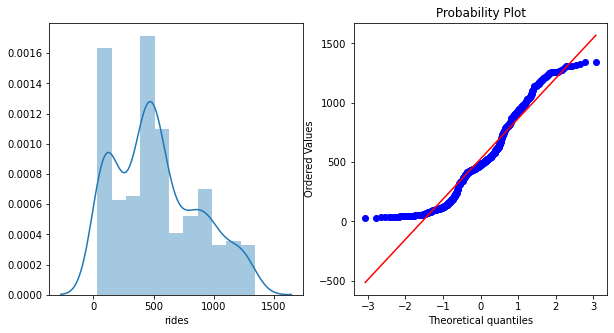

In [201]:
fig,axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
dist = sns.distplot(dataset_hourly[COL_BIKES_RIDES],ax=axes[0])
prob = stats.probplot(dataset_hourly[COL_BIKES_RIDES], dist='norm', fit=True, plot=axes[1])

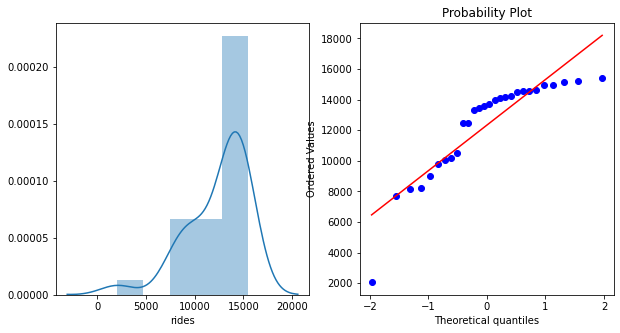

In [202]:
fig,axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
dist = sns.distplot(dataset_daily[COL_BIKES_RIDES],ax=axes[0]) # was macht distplot?
prob = stats.probplot(dataset_daily[COL_BIKES_RIDES], dist='norm', fit=True, plot=axes[1])

Test Shapiro para confirmar hipótesis de normalidad: (rechazo de hipótesis si p < 0.05)

In [203]:
from scipy.stats import shapiro
stat_hourly, p_hourly = shapiro(dataset_hourly[COL_BIKES_RIDES])
stat_daily, p_daily = shapiro(dataset_daily[COL_BIKES_RIDES])
print("Dataset horario: ")
print(stat_hourly, p_hourly)
print("Dataset diario: ")
print(stat_daily, p_daily)

Dataset horario: 
0.9461052417755127 1.0338342900132694e-14
Dataset diario: 
0.8222179412841797 0.00027004245202988386


Nuestros datos no siguen una distribución normal, por lo que debemos tener cuidado a la hora de aplicar modelos de machine learning (cada modelo asume un conjunto de hipótesis). Una opción sería transformar dicha variable usando una transformación log-normal. o una función boxcox [TODO]

Transformación log-normal a datos horarios

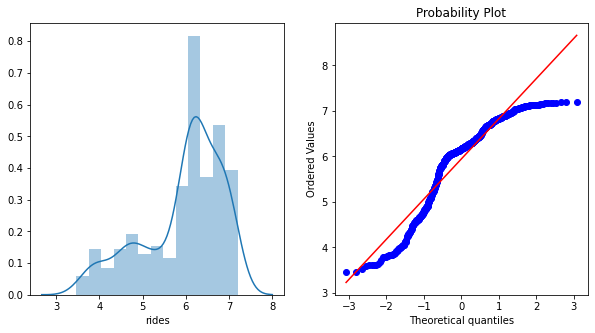

In [204]:
fig,axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
dist = sns.distplot(np.log(dataset_hourly[COL_BIKES_RIDES]),ax=axes[0])
prob = stats.probplot(np.log(dataset_hourly[COL_BIKES_RIDES]),  dist='norm', fit=True, plot=axes[1])

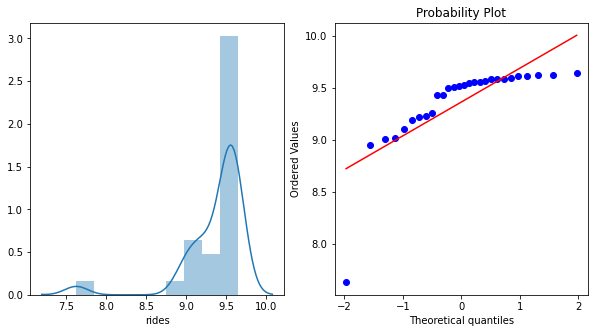

In [205]:
fig,axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
dist = sns.distplot(np.log(dataset_daily[COL_BIKES_RIDES]),ax=axes[0])
prob = stats.probplot(np.log(dataset_daily[COL_BIKES_RIDES]),  dist='norm', fit=True, plot=axes[1])

Seguimos sin tener un resultado idealmente normal. 

### Modelo de regresión lineal

Modelo de regresión lineal utilizando sólo variables climáticas:

In [210]:
dataset_daily_lognormal = dataset_daily.copy()
dataset_daily_lognormal[COL_BIKES_RIDES] = np.log(dataset_daily_lognormal[COL_BIKES_RIDES])

In [211]:
train_daily, test_daily = prepare_data(dataset_daily)
train_daily_lognormal, test_daily_lognormal = prepare_data(dataset_daily_lognormal)

In [212]:
linear_regression_model_daily = create_linear_regression_model()
linear_regression_model_daily = train(linear_regression_model_daily, train_daily, features_columns=[COL_WEATHER_TEMP_MEAN, 
                                                                                                    COL_WEATHER_RAIN, 
                                                                                                    COL_WEATHER_WIND_MEAN], target_column=TARGET)
rmse_daily_weather = evaluate(linear_regression_model_daily, test_daily, features_columns=[COL_WEATHER_TEMP_MEAN, 
                                                                      COL_WEATHER_RAIN, 
                                                                      COL_WEATHER_WIND_MEAN], target_column=TARGET, metric='rmse')
print('RMSE (modelo diario, variables climatológicas): {}'.format(rmse_daily_weather))

RMSE (modelo diario, variables climatológicas): 53.84954033326276


Añadiendo el día de la semana:

In [213]:
linear_regression_model_daily = create_linear_regression_model()
linear_regression_model_daily = train(linear_regression_model_daily, train_daily, features_columns=[COL_WEATHER_TEMP_MEAN, 
                                                                                                    COL_WEATHER_RAIN, 
                                                                                                    COL_WEATHER_WIND_MEAN,
                                                                                                    'weekend_weekend',
                                                                                                    'weekend_weekend'] , target_column=TARGET)
rmse_daily_weather_weekend = evaluate(linear_regression_model_daily, test_daily, features_columns=[COL_WEATHER_TEMP_MEAN, 
                                                                                                     COL_WEATHER_RAIN, 
                                                                                                     COL_WEATHER_WIND_MEAN,
                                                                                                    'weekend_weekend',
                                                                                                    'weekend_weekend'], target_column=TARGET, metric='rmse')
print('RMSE (modelo diario, variables climatológicas + fin de semana/entre semana): {}'.format(rmse_daily_weather_weekend))

RMSE (modelo diario, variables climatológicas + fin de semana/entre semana): 38.87682629267761


In [214]:
linear_regression_model_daily = create_linear_regression_model()
linear_regression_model_daily = train(linear_regression_model_daily, train_daily, features_columns=[COL_WEATHER_TEMP_MEAN, 
                                                                                                    COL_WEATHER_RAIN, 
                                                                                                    COL_WEATHER_WIND_MEAN] + ENCODED_CATEGORIAL_COLUMNS_DAILY, target_column=TARGET)
rmse_daily_weather_dayofweek = evaluate(linear_regression_model_daily, test_daily, features_columns=[COL_WEATHER_TEMP_MEAN, 
                                                                      COL_WEATHER_RAIN, 
                                                                      COL_WEATHER_WIND_MEAN] + ENCODED_CATEGORIAL_COLUMNS_DAILY, target_column=TARGET, metric='rmse')
print('RMSE (modelo diario, variables climatológicas + día de la semana + fin de semana/entre semana): {}'.format(rmse_daily_weather_dayofweek))

RMSE (modelo diario, variables climatológicas + día de la semana + fin de semana/entre semana): 38.87682629267761


Añadiendo la cantidad media de trayectos para ese día de la semana:

In [216]:
linear_regression_model_daily = create_linear_regression_model()
linear_regression_model_daily = train(linear_regression_model_daily, train_daily, features_columns=[COL_WEATHER_TEMP_MEAN, 
                                                                                                    COL_WEATHER_RAIN, 
                                                                                                    COL_WEATHER_WIND_MEAN,
                                                                                                    COL_BIKES_RIDES_MEAN_WEEKDAY] + ENCODED_CATEGORIAL_COLUMNS_DAILY, target_column=TARGET)
rmse_daily_weather_dayofweek_meanrides = evaluate(linear_regression_model_daily, test_daily, features_columns=[COL_WEATHER_TEMP_MEAN, 
                                                                                                     COL_WEATHER_RAIN, 
                                                                                                     COL_WEATHER_WIND_MEAN,
                                                                                                     COL_BIKES_RIDES_MEAN_WEEKDAY] + ENCODED_CATEGORIAL_COLUMNS_DAILY, target_column=TARGET, metric='rmse')
print('RMSE (modelo diario, variables climatológicas + día de la semana + fin de semana/entre semana + número medio de trayectos para ese día de la semana): {}'.format(rmse_daily_weather_dayofweek_meanrides))

RMSE (modelo diario, variables climatológicas + día de la semana + fin de semana/entre semana + número medio de trayectos para ese día de la semana): 39.663695871568464
